BLOQUE 0 – Imports, Drive y rutas

In [1]:
# ============================================================
# BLOQUE 0: Imports, montaje de Drive y rutas base
# ============================================================

!pip install scikit-learn joblib imbalanced-learn --quiet

from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path
import pandas as pd
import numpy as np

# ============ RUTAS BASE ============
BASE_CIC = Path("/content/drive/MyDrive/Colab Notebooks/Datasets/CIC-IDS2017-Full")
BASE_CONN = Path("/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/conn_logs")
OUT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3")

OUT_DIR.mkdir(parents=True, exist_ok=True)

# ============ LISTA DE CSVs CICIDS2017 (FULL) ============
CIC_FILES = [
    "Monday-WorkingHours.pcap_ISCX.csv",
    "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday-workingHours.pcap_ISCX.csv",
    "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
]

# ============ LISTA DE conn.log DE ZEEK ============
CONN_FILES = [
    "conn_monday_full.log",
    "conn_tuesday_full.log",
    "conn_wednesday_full.log",
    "conn_thursday_full.log",
    "conn_friday_full.log",
]

# Ruta del modelo de salida (solo 6 clases)
MODEL_OUT_PATH = OUT_DIR / "rf_cicids2017_zeek_6clases.pkl"

print("BASE_CIC:", BASE_CIC)
print("BASE_CONN:", BASE_CONN)
print("CSV CICIDS:", CIC_FILES)
print("CONN logs Zeek:", CONN_FILES)
print("Modelo se guardará en:", MODEL_OUT_PATH)


Mounted at /content/drive
BASE_CIC: /content/drive/MyDrive/Colab Notebooks/Datasets/CIC-IDS2017-Full
BASE_CONN: /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/conn_logs
CSV CICIDS: ['Monday-WorkingHours.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv', 'Wednesday-workingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv']
CONN logs Zeek: ['conn_monday_full.log', 'conn_tuesday_full.log', 'conn_wednesday_full.log', 'conn_thursday_full.log', 'conn_friday_full.log']
Modelo se guardará en: /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/rf_cicids2017_zeek_6clases.pkl


BLOQUE 1 – Funciones de carga (conn.log + CICIDS)

In [2]:
# ============================================================
# BLOQUE 1: Funciones de carga para conn.log y CICIDS
# ============================================================

def read_zeek_conn(path: Path) -> pd.DataFrame:
    """
    Lee un conn.log de Zeek:
    - Busca la línea '#fields'
    - Usa esos campos como nombres de columnas
    - Ignora líneas de comentarios
    """
    path = str(path)
    cols = None
    data = []
    with open(path, "r") as f:
        for line in f:
            if line.startswith("#fields"):
                cols = line.strip().split("\t")[1:]
                continue
            if line.startswith("#"):
                continue
            if cols is None:
                raise ValueError(f"No se encontró la línea '#fields' en {path}")
            parts = line.strip().split("\t")
            if len(parts) != len(cols):
                continue
            data.append(parts)

    df = pd.DataFrame(data, columns=cols)

    for col in ["id.orig_p", "id.resp_p", "duration", "orig_bytes", "resp_bytes", "orig_pkts", "resp_pkts"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df


def load_all_conn() -> dict:
    """
    Carga TODOS los conn.log listados en CONN_FILES
    y devuelve un dict {day: DataFrame}.
    """
    conn_all = {}
    print("=== Cargando TODOS los conn.log de Zeek ===")
    for fname in CONN_FILES:
        # conn_monday_full.log -> monday
        day = fname.split("_")[1]
        day = day.replace(".log", "")
        df_conn = read_zeek_conn(BASE_CONN / fname)
        df_conn["__day"] = day
        conn_all[day] = df_conn
        print(f"  {day}: {df_conn.shape}")
    return conn_all


def load_all_cic() -> dict:
    """
    Carga TODOS los CSV FULL de CICIDS2017 listados en CIC_FILES
    y devuelve un dict {day: [DataFrame, ...]}.
    """
    cic_all = {}
    print("\n=== Cargando TODOS los CSV FULL de CICIDS2017 ===")
    for fname in CIC_FILES:
        df_cic = pd.read_csv(BASE_CIC / fname, encoding="latin1", low_memory=False)
        df_cic["__source"] = fname
        df_cic["__day"] = fname.split("-")[0].lower()  # monday / tuesday / ...
        day = df_cic["__day"].iloc[0]
        cic_all.setdefault(day, []).append(df_cic)
        print(f"  {fname}: {df_cic.shape}")
    return cic_all


BLOQUE 2 – Merge día por día (Zeek + CICIDS → df)

In [3]:
# ============================================================
# BLOQUE 2: Merge día por día Zeek conn.log + CICIDS2017
# ============================================================

conn_all = load_all_conn()
cic_all = load_all_cic()

# Normalizar CICIDS
for day, dfs in cic_all.items():
    for i, df_x in enumerate(dfs):
        df_x.columns = df_x.columns.str.strip()
        df_x["Flow ID"] = df_x["Flow ID"].astype(str).str.strip()
        cic_all[day][i] = df_x

merged_days = []

for day, zeek_df in conn_all.items():
    print(f"\n=== Procesando día: {day} ===")

    z = zeek_df.copy()
    z["Source IP"]        = z["id.orig_h"]
    z["Destination IP"]   = z["id.resp_h"]
    z["Source Port"]      = pd.to_numeric(z["id.orig_p"], errors="coerce")
    z["Destination Port"] = pd.to_numeric(z["id.resp_p"], errors="coerce")

    proto_map = {"tcp": 6, "udp": 17, "icmp": 1}
    z["Protocol"] = z["proto"].map(proto_map).fillna(0).astype(int)

    z["Flow ID"] = (
        z["Source IP"].astype(str) + "-" +
        z["Destination IP"].astype(str) + "-" +
        z["Source Port"].astype("Int64").astype(str) + "-" +
        z["Destination Port"].astype("Int64").astype(str) + "-" +
        z["Protocol"].astype(str)
    )

    if day not in cic_all:
        print(f"  ⚠ No hay CSVs CICIDS para {day}. Saltando.")
        continue

    cic_concat = pd.concat(cic_all[day], ignore_index=True)

    merged_day = z.merge(
        cic_concat[["Flow ID", "Label"]],
        on="Flow ID",
        how="inner"
    )

    print(f"  Flujos etiquetados: {merged_day.shape[0]}")
    merged_days.append(merged_day)

df = pd.concat(merged_days, ignore_index=True)

print("\n=================================================")
print("MERGE FINAL COMPLETADO - DataFrame 'df'")
print("Forma final:", df.shape)
print("=================================================")
print("Distribución Label original en df:")
print(df["Label"].value_counts())


=== Cargando TODOS los conn.log de Zeek ===
  monday: (375432, 23)
  tuesday: (323342, 23)
  wednesday: (509362, 23)
  thursday: (363788, 23)
  friday: (547353, 23)

=== Cargando TODOS los CSV FULL de CICIDS2017 ===
  Monday-WorkingHours.pcap_ISCX.csv: (529918, 87)
  Tuesday-WorkingHours.pcap_ISCX.csv: (445909, 87)
  Wednesday-workingHours.pcap_ISCX.csv: (692703, 87)
  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv: (458968, 87)
  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv: (288602, 87)
  Friday-WorkingHours-Morning.pcap_ISCX.csv: (191033, 87)
  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv: (286467, 87)
  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv: (225745, 87)

=== Procesando día: monday ===
  Flujos etiquetados: 589071

=== Procesando día: tuesday ===
  Flujos etiquetados: 705136

=== Procesando día: wednesday ===
  Flujos etiquetados: 4064201

=== Procesando día: thursday ===
  Flujos etiquetados: 529066

=== Procesando día: friday ===
  Flujos

BLOQUE 3 – Mapeo de labels + filtrar clases

In [4]:
# ============================================================
# BLOQUE 3: Mapeo de Label -> Label_mapped y filtrado a 6 clases
# ============================================================

def map_label_6(label: str) -> str:
    raw = str(label).strip()
    low = raw.lower()

    # BENIGN
    if raw == "BENIGN":
        return "BENIGN"

    # DOS (DoS Hulk, DoS GoldenEye, DoS slowloris, DoS Slowhttptest, etc.)
    if "dos" in low and "ddos" not in low:
        return "DOS"

    # DDOS
    if "ddos" in low:
        return "DDOS"

    # BOT
    if "bot" in low:
        return "BOT"

    # BRUTE_FORCE (FTP-Patator, SSH-Patator, Web Attack – Brute Force)
    if "patator" in low or "brute force" in low or "bruteforce" in low:
        return "BRUTE_FORCE"

    # PORTSCAN
    if "portscan" in low:
        return "PORTSCAN"

    # TODO lo demás se va a OTHER (no lo usaremos en el modelo)
    return "OTHER"


df["Label_mapped"] = df["Label"].apply(map_label_6)

print("Distribución Label_mapped (todas las clases):")
print(df["Label_mapped"].value_counts())

# Nos quedamos SOLO con las 6 clases objetivo
WANTED_CLASSES = ["BENIGN", "DOS", "DDOS", "BOT", "BRUTE_FORCE", "PORTSCAN"]
df = df[df["Label_mapped"].isin(WANTED_CLASSES)].reset_index(drop=True)

print("\nDistribución Label_mapped tras filtrar a 6 clases:")
print(df["Label_mapped"].value_counts())


Distribución Label_mapped (todas las clases):
Label_mapped
DOS            3434791
BENIGN         3077830
DDOS            370287
PORTSCAN        160457
BRUTE_FORCE      15410
BOT               2988
OTHER              744
Name: count, dtype: int64

Distribución Label_mapped tras filtrar a 6 clases:
Label_mapped
DOS            3434791
BENIGN         3077830
DDOS            370287
PORTSCAN        160457
BRUTE_FORCE      15410
BOT               2988
Name: count, dtype: int64


BLOQUE 4 – Features desde conn.log + limpieza ligera

In [5]:
# ============================================================
# BLOQUE 4: Features derivadas + limpieza ligera (sin matar PortScan)
# ============================================================

# Aseguramos columnas numéricas clave
for col in ["duration", "orig_bytes", "resp_bytes", "orig_pkts", "resp_pkts"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# Métricas de bytes y paquetes
df["bytes_total"] = df["orig_bytes"] + df["resp_bytes"]
df["bytes_ratio"] = (df["orig_bytes"] + 1) / (df["resp_bytes"] + 1)
df["pkts_total"]  = df["orig_pkts"] + df["resp_pkts"]
df["pkts_ratio"]  = (df["orig_pkts"] + 1) / (df["resp_pkts"] + 1)

# One-hot simple de protocolo
df["proto_tcp"]  = (df["proto"] == "tcp").astype(int)
df["proto_udp"]  = (df["proto"] == "udp").astype(int)
df["proto_icmp"] = (df["proto"] == "icmp").astype(int)

# Flags HTTP / SSH
df["is_http"] = df["id.resp_p"].isin([80, 8080, 443]).astype(int)
df["is_ssh"]  = (df["id.resp_p"] == 22).astype(int)

# SOLO quitamos valores negativos (datos corruptos)
mask_bad = (
    (df["duration"] < 0) |
    (df["orig_bytes"] < 0) |
    (df["resp_bytes"] < 0)
)
print("Filas con valores negativos (se eliminan):", mask_bad.sum())
df = df.loc[~mask_bad].reset_index(drop=True)
print("Shape después de limpiar negativos:", df.shape)

features = [
    "duration",
    "orig_bytes", "resp_bytes",
    "orig_pkts", "resp_pkts",
    "bytes_total", "bytes_ratio",
    "pkts_total", "pkts_ratio",
    "proto_tcp", "proto_udp", "proto_icmp",
    "is_http", "is_ssh",
]

X_full = df[features].replace([np.inf, -np.inf], 0).fillna(0)
y_full = df["Label_mapped"].copy()

print("Distribución de clases (antes de balanceo):")
print(y_full.value_counts())


Filas con valores negativos (se eliminan): 0
Shape después de limpiar negativos: (7061763, 40)
Distribución de clases (antes de balanceo):
Label_mapped
DOS            3434791
BENIGN         3077830
DDOS            370287
PORTSCAN        160457
BRUTE_FORCE      15410
BOT               2988
Name: count, dtype: int64


BLOQUE 5 – Balanceo híbrido (undersampling + SMOTE)

In [6]:
# ============================================================
# BLOQUE 5: Balanceo para 6 clases (undersampling + SMOTE)
# ============================================================

from imblearn.over_sampling import SMOTE

# 1) Undersampling manual para clases muy grandes
df_us = []

MAX_SAMPLES = {
    "BENIGN":   80000,
    "DOS":      70000,
    "DDOS":     50000,
    "PORTSCAN": 20000,
    # BOT y BRUTE_FORCE no se tocan aquí (son minoritarias)
}

for cls, group in df.groupby("Label_mapped"):
    limit = MAX_SAMPLES.get(cls, None)
    if limit is not None and len(group) > limit:
        print(f"Undersampling {cls}: {len(group)} → {limit}")
        group = group.sample(limit, random_state=42)
    else:
        print(f"Clase {cls}: {len(group)} (sin undersampling)")
    df_us.append(group)

df_us = pd.concat(df_us, ignore_index=True)
print("\nDistribución tras undersampling:")
print(df_us["Label_mapped"].value_counts())

# 2) SMOTE para clases intermedias
X = df_us[features].replace([np.inf, -np.inf], 0).fillna(0)
y = df_us["Label_mapped"].copy()

print("\nDistribución antes de SMOTE:")
print(y.value_counts())

TARGET_SMOTE = 15000  # objetivo para minoritarias (BOT, BRUTE_FORCE, quizá PORTSCAN)

class_counts = y.value_counts()
sampling_strategy = {}

for cls, count in class_counts.items():
    if 300 <= count < TARGET_SMOTE:
        sampling_strategy[cls] = TARGET_SMOTE
        print(f"SMOTE para {cls}: {count} → {TARGET_SMOTE}")
    else:
        print(f"SMOTE NO se aplica a {cls} (tiene {count})")

if sampling_strategy:
    smote = SMOTE(
        sampling_strategy=sampling_strategy,
        k_neighbors=5,
        random_state=42
    )
    X_res, y_res = smote.fit_resample(X, y)
else:
    print("⚠ No se definió ninguna estrategia de SMOTE; usamos df_us tal cual")
    X_res, y_res = X.copy(), y.copy()

print("\nDistribución después de SMOTE:")
print(pd.Series(y_res).value_counts())


Undersampling BENIGN: 3077830 → 80000
Clase BOT: 2988 (sin undersampling)
Clase BRUTE_FORCE: 15410 (sin undersampling)
Undersampling DDOS: 370287 → 50000
Undersampling DOS: 3434791 → 70000
Undersampling PORTSCAN: 160457 → 20000

Distribución tras undersampling:
Label_mapped
BENIGN         80000
DOS            70000
DDOS           50000
PORTSCAN       20000
BRUTE_FORCE    15410
BOT             2988
Name: count, dtype: int64

Distribución antes de SMOTE:
Label_mapped
BENIGN         80000
DOS            70000
DDOS           50000
PORTSCAN       20000
BRUTE_FORCE    15410
BOT             2988
Name: count, dtype: int64
SMOTE NO se aplica a BENIGN (tiene 80000)
SMOTE NO se aplica a DOS (tiene 70000)
SMOTE NO se aplica a DDOS (tiene 50000)
SMOTE NO se aplica a PORTSCAN (tiene 20000)
SMOTE NO se aplica a BRUTE_FORCE (tiene 15410)
SMOTE para BOT: 2988 → 15000

Distribución después de SMOTE:
Label_mapped
BENIGN         80000
DOS            70000
DDOS           50000
PORTSCAN       20000
BRUTE_FO

BLOQUE 6 – Entrenar RF + métricas + matriz de confusión

=== MÉTRICAS GLOBALES DEL MODELO (6 clases) ===


,Accuracy (%),Precision_macro (%),Recall_macro (%),F1_macro (%),Precision_weighted (%),Recall_weighted (%),F1_weighted (%),AUC_macro (%),Train_time_s,Predict_time_s
0,96.451819,97.004658,97.426966,97.16459,96.553384,96.451819,96.415246,99.295776,16.442018,0.406728



=== REPORT POR CLASE (Label_mapped) ===
              precision    recall  f1-score   support

      BENIGN       0.99      0.90      0.94     16000
         BOT       1.00      1.00      1.00      3000
 BRUTE_FORCE       0.97      0.96      0.96      3082
        DDOS       0.95      0.99      0.97     10000
         DOS       0.95      1.00      0.97     14000
    PORTSCAN       0.98      0.99      0.99      4000

    accuracy                           0.96     50082
   macro avg       0.97      0.97      0.97     50082
weighted avg       0.97      0.96      0.96     50082


Etiquetas (ordenadas): ['BENIGN', 'BOT', 'BRUTE_FORCE', 'DDOS', 'DOS', 'PORTSCAN']
Matriz de confusión (filas = reales, columnas = predichas):
[[14475    10   104   540   802    69]
 [    2  2998     0     0     0     0]
 [  128     0  2954     0     0     0]
 [   67     0     0  9927     0     6]
 [   12     1     0     0 13985     2]
 [    3     0     0    29     2  3966]]


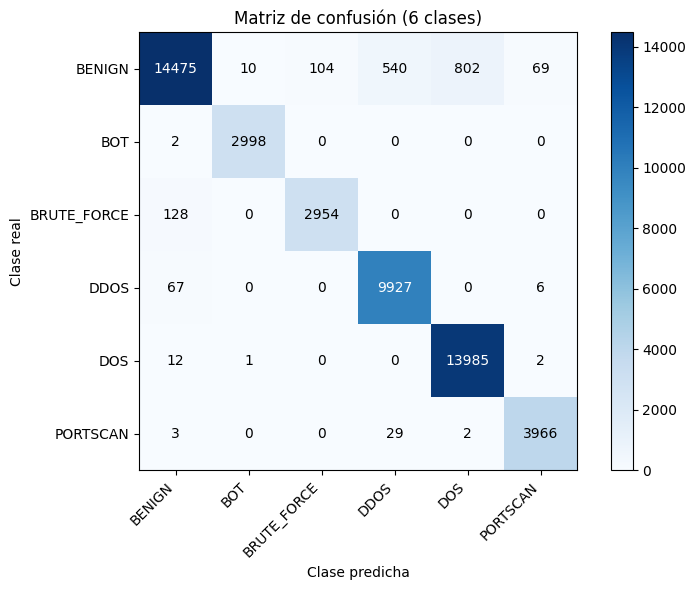

In [7]:
# ============================================================
# BLOQUE 6: Entrenamiento RF + métricas + matriz de confusión
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import time

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.2,
    stratify=y_res,
    random_state=42,
)

clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
)

t0 = time.time()
clf.fit(X_train, y_train)
t1 = time.time()
train_time_s = t1 - t0

t0_pred = time.time()
y_pred = clf.predict(X_test)
t1_pred = time.time()
predict_time_s = t1_pred - t0_pred

# Métricas globales
acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)
prec_weight, rec_weight, f1_weight, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted", zero_division=0
)

classes_sorted = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes_sorted)
y_pred_proba = clf.predict_proba(X_test)
try:
    auc_macro = roc_auc_score(y_test_bin, y_pred_proba, average="macro", multi_class="ovr")
except ValueError:
    auc_macro = np.nan

metrics_model_df = pd.DataFrame([{
    "Accuracy (%)":              acc * 100,
    "Precision_macro (%)":       prec_macro * 100,
    "Recall_macro (%)":          rec_macro * 100,
    "F1_macro (%)":              f1_macro * 100,
    "Precision_weighted (%)":    prec_weight * 100,
    "Recall_weighted (%)":       rec_weight * 100,
    "F1_weighted (%)":           f1_weight * 100,
    "AUC_macro (%)":             auc_macro * 100 if not np.isnan(auc_macro) else np.nan,
    "Train_time_s":              train_time_s,
    "Predict_time_s":            predict_time_s,
}])

print("=== MÉTRICAS GLOBALES DEL MODELO (6 clases) ===")
display(metrics_model_df)

print("\n=== REPORT POR CLASE (Label_mapped) ===")
print(classification_report(y_test, y_pred, zero_division=0))

# Matriz de confusión (azul)
labels = sorted(np.unique(y_res))
cm = confusion_matrix(y_test, y_pred, labels=labels)

print("\nEtiquetas (ordenadas):", labels)
print("Matriz de confusión (filas = reales, columnas = predichas):")
print(cm)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Matriz de confusión (6 clases)")
plt.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)

ax.set_ylabel("Clase real")
ax.set_xlabel("Clase predicha")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()


BLOQUE 7 – CSV “alert-ready”

In [8]:
# ============================================================
# BLOQUE 7: CSV general 'alert-ready' (solo 6 clases)
# ============================================================

df_alert = df_us.copy()  # dataset tras undersampling (sin SMOTE)

if "service" not in df_alert.columns:
    df_alert["service"] = "-"
if "conn_state" not in df_alert.columns:
    df_alert["conn_state"] = "-"

cols_alert = [
    "ts", "uid",
    "id.orig_h", "id.orig_p",
    "id.resp_h", "id.resp_p",
    "proto", "service", "conn_state",
    "duration", "orig_bytes", "resp_bytes",
    "orig_pkts", "resp_pkts",
    "bytes_total", "bytes_ratio",
    "pkts_total", "pkts_ratio",
    "proto_tcp", "proto_udp", "proto_icmp",
    "is_http", "is_ssh",
    "Label",
    "Label_mapped",
]

missing_cols = [c for c in cols_alert if c not in df_alert.columns]
if missing_cols:
    raise ValueError(f"Faltan columnas en df_alert: {missing_cols}")

OUT_CSV_ALERT = OUT_DIR / "zeek_cicids2017_6clases_alert_ready.csv"
df_alert[cols_alert].to_csv(OUT_CSV_ALERT, index=False)
print("📁 CSV general de alertas (6 clases) guardado en:", OUT_CSV_ALERT)


📁 CSV general de alertas (6 clases) guardado en: /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/zeek_cicids2017_6clases_alert_ready.csv


BLOQUE 8 – Hasta 50 registros bien clasificados por clase

In [9]:
# ============================================================
# BLOQUE 8: Samples correctamente clasificados por clase (6 clases)
# ============================================================

X_eval = df_alert[features].replace([np.inf, -np.inf], 0).fillna(0)
y_eval_true = df_alert["Label_mapped"]
y_eval_pred = clf.predict(X_eval)

df_eval = df_alert.copy()
df_eval["Label_mapped_pred"] = y_eval_pred

df_correct = df_eval[df_eval["Label_mapped"] == df_eval["Label_mapped_pred"]].copy()
print("Total de filas correctamente clasificadas:", df_correct.shape[0])

EXPORT_COLS = [
    "ts", "uid",
    "id.orig_h", "id.orig_p",
    "id.resp_h", "id.resp_p",
    "proto", "service", "conn_state",
    "duration", "orig_bytes", "resp_bytes",
    "orig_pkts", "resp_pkts",
    "bytes_total", "bytes_ratio",
    "pkts_total", "pkts_ratio",
    "proto_tcp", "proto_udp", "proto_icmp",
    "is_http", "is_ssh",
    "Label",
]

samples_dir = OUT_DIR / "samples_correctos_6clases"
samples_dir.mkdir(parents=True, exist_ok=True)

info_rows = []

for cls in sorted(df_correct["Label_mapped"].unique()):
    sub = df_correct[df_correct["Label_mapped"] == cls]
    sub_export = sub[EXPORT_COLS].head(50)
    out_path = samples_dir / f"correct_{cls}.csv"
    sub_export.to_csv(out_path, index=False)
    info_rows.append((cls, len(sub_export), str(out_path)))
    print(f"{cls:12s} -> {len(sub_export):3d} filas guardadas en {out_path}")

info_rows


Total de filas correctamente clasificadas: 230582
BENIGN       ->  50 filas guardadas en /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/samples_correctos_6clases/correct_BENIGN.csv
BOT          ->  50 filas guardadas en /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/samples_correctos_6clases/correct_BOT.csv
BRUTE_FORCE  ->  50 filas guardadas en /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/samples_correctos_6clases/correct_BRUTE_FORCE.csv
DDOS         ->  50 filas guardadas en /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/samples_correctos_6clases/correct_DDOS.csv
DOS          ->  50 filas guardadas en /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/samples_correctos_6clases/correct_DOS.csv
PORTSCAN     ->  50 filas guardadas en /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/samples_correctos_6clases/correct_PORTSCAN.csv


[('BENIGN',
  50,
  '/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/samples_correctos_6clases/correct_BENIGN.csv'),
 ('BOT',
  50,
  '/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/samples_correctos_6clases/correct_BOT.csv'),
 ('BRUTE_FORCE',
  50,
  '/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/samples_correctos_6clases/correct_BRUTE_FORCE.csv'),
 ('DDOS',
  50,
  '/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/samples_correctos_6clases/correct_DDOS.csv'),
 ('DOS',
  50,
  '/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/samples_correctos_6clases/correct_DOS.csv'),
 ('PORTSCAN',
  50,
  '/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/samples_correctos_6clases/correct_PORTSCAN.csv')]

BLOQUE 9 – Guardar el modelo

In [10]:
# ============================================================
# BLOQUE 9: Guardar el modelo RF (6 clases)
# ============================================================

import joblib

bundle = {
    "model": clf,
    "features": features,
    "classes": clf.classes_.tolist(),
}

MODEL_OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(bundle, MODEL_OUT_PATH)

print("✅ Modelo (6 clases) guardado en:", MODEL_OUT_PATH)
bundle


✅ Modelo (6 clases) guardado en: /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017_v3/rf_cicids2017_zeek_6clases.pkl


{'model': RandomForestClassifier(min_samples_leaf=2, n_estimators=400, n_jobs=-1,
                        random_state=42),
 'features': ['duration',
  'orig_bytes',
  'resp_bytes',
  'orig_pkts',
  'resp_pkts',
  'bytes_total',
  'bytes_ratio',
  'pkts_total',
  'pkts_ratio',
  'proto_tcp',
  'proto_udp',
  'proto_icmp',
  'is_http',
  'is_ssh'],
 'classes': ['BENIGN', 'BOT', 'BRUTE_FORCE', 'DDOS', 'DOS', 'PORTSCAN']}